### Import and configure modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import models, backend as K

In [2]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ADAPTIVE)
  
  img = tf.keras.preprocessing.image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [3]:
def show_image(image,title=None):
    if len(image.shape)>3:
        image=tf.squeeze(image,axis=0)
    plt.imshow(image) 
    if title:
        plt.title=title
    plt.show()

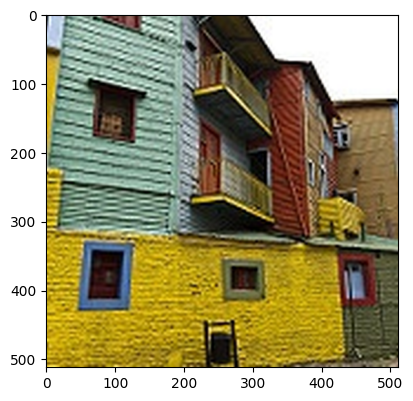

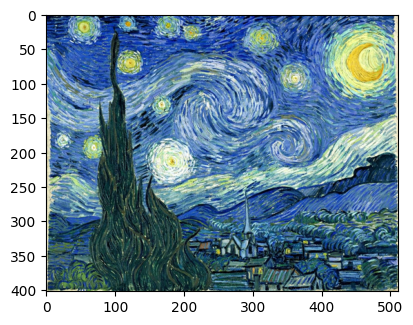

In [4]:
content_path = "d:/Study Materials/4-2/paint like any painter/Image_data/photo_jpg/1.jpg"
style_path = "d:/Study Materials/4-2/paint like any painter/Image_data/VG_image/Vincent_van_Gogh_368.jpg"

plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
show_image(content, 'Content Image')

plt.subplot(1, 2, 2)
show_image(style, 'Style Image')
plt.show()

In [5]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img

In [6]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [7]:
resnet = tf.keras.applications.resnet50.ResNet50(weights='imagenet')
content_layers = ['conv1_conv']
style_layers = ['conv2_block1_1_conv', 'conv3_block1_1_conv', 'conv4_block5_1_conv', 'conv5_block2_1_conv']
num_content_layers = 1
num_style_layers = 4

In [8]:
def get_model():
  resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
  resnet.trainable = False
  style_outputs = [resnet.get_layer(name).output for name in style_layers]
  content_outputs = [resnet.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  return models.Model(resnet.input, model_outputs)

In [9]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [10]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style - gram_target)) 

In [11]:
def get_feature_representations(model,content_path, style_path):
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [12]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [13]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)

  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [14]:
import IPython.display

def run_style_transfer(content_path, style_path,num_iterations=1000,content_weight=1, style_weight=1e6): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  optimizer = tf.optimizers.Adam(learning_rate=20, beta_1=0.99, epsilon=1e-1)
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  # save losses each iteration
  losses = []

  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    optimizer.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    print(". ", end="") # Fo tracking progress
    losses.append(loss)
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))

  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

      
  return best_img, best_loss,losses

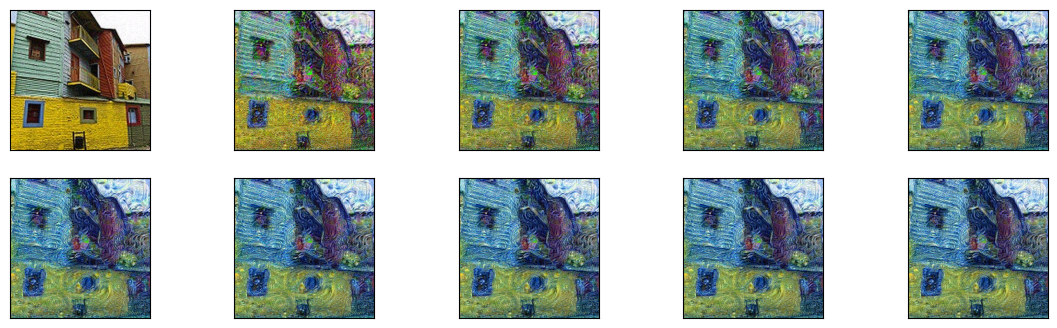

In [15]:
best, best_loss,losses = run_style_transfer(content_path,style_path, num_iterations=1000)

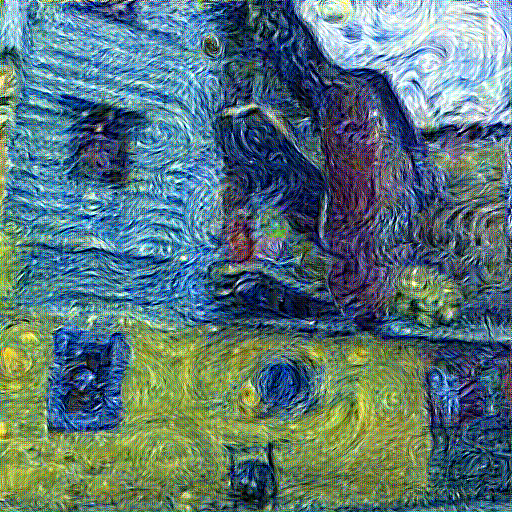

In [16]:
Image.fromarray(best)

In [17]:
Image.fromarray(best).save("out.jpg", "JPEG", quality=80, optimize=True, progressive=True)

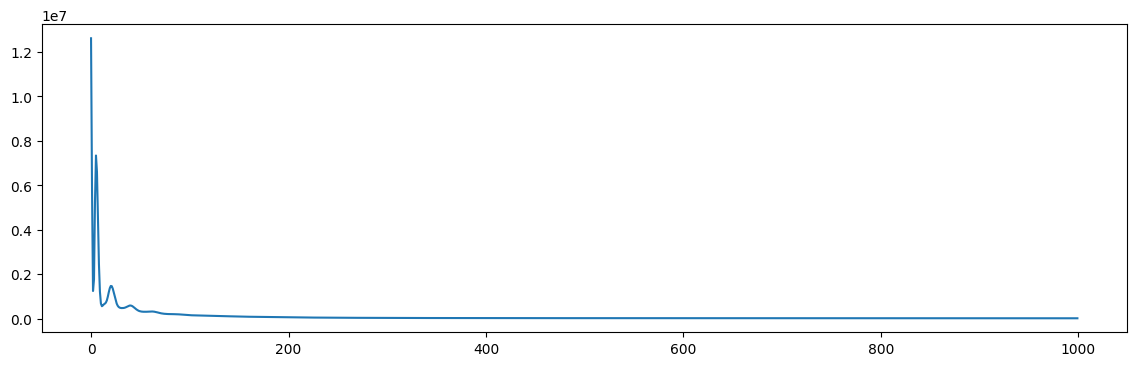

In [20]:
# plot losses
plt.figure(figsize=(14,4))
plt.plot(losses)
plt.savefig('losses.png')
plt.show()


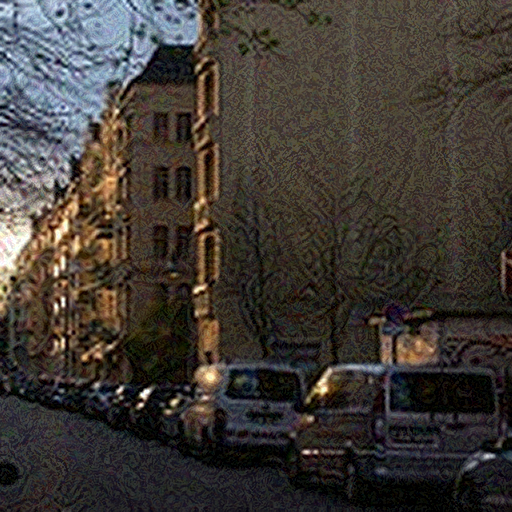

Iteration: 0
Total loss: 1.6449e+07, style loss: 1.6449e+07, content loss: 0.0000e+00, time: 0.0464s
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [23]:
content_paths = "d:/Study Materials/4-2/paint like any painter/Image_data/photo_jpg/" 
import os
if not os.path.exists("d:/Study Materials/4-2/paint like any painter/Image_data/resnet_image"):
    os.makedirs("d:/Study Materials/4-2/paint like any painter/Image_data/resnet_image", exist_ok=True)
dir = "d:/Study Materials/4-2/paint like any painter/Image_data/resnet_image"

for i in range(252):
    style_path = "d:/Study Materials/4-2/paint like any painter/Image_data/VG_image/Vincent_van_Gogh_368.jpg"
    content_path = content_paths + "/" + str(i) + ".jpg"
    best, best_loss,losses = run_style_transfer(content_path,style_path, num_iterations=1000)
    Image.fromarray(best).save(dir + "/" + str(i) + ".jpg", "JPEG", quality=80, optimize=True, progressive=True)
